<a href="https://colab.research.google.com/github/CarolinaGarza22/LauraCarolinaGarzaLozano/blob/main/P4_LCGL_HH_Laboratorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo biofisico de Hodgkin-Huxley

Despues de su trabajo experimental, Hodgkin y Huxley desarrollaron un modelo biofisico para explicar el comportamiento de la respueta de la membrana celular de la neurona. En este modelo, se consideran principalmente la contribucion de los canales ionicos de Na y K. Respuestas que puedieron explicar mediante la introduccion de 3 funciones probabilisticas dependientes del voltaje de la membrana medido determinadas n, m & h. Las variables n y m describe la probabilidad de que el total de canales ionicos de Na o K se encuentren abiertos al mismo tiempo (y no la duracion de apertura del canal ionico), mientras que la probabilidad h describe un fenomeno de inactivacion particularmente asociado a los canales ionicos del Na.

Mediante este laboratorio, recreara el modelo de respueta de la membrana celular segun los hallazgos de H-H. Para lograrlo, requerira introducir las ecuaciones preparadas para este modelo simplificado en los espacios correspondientes, los espacios en donde encuentre un `None`.

El estado actual de esta libreta muestra el resultado esperado en 2 graficas. La primera, el estimulo inyectado a la membrana celular y la respuesta en el tiempo de la membrana. La segunda, el comportamiento de las variables n, m & h en el tiempo paralelas a la respuesta en Volts de la membrana.

**Importar las librerias requeridias**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math


**Definir las funciones caracteristicas de los canales ionicos**

Para las 3 funciones de probabilidad, la misma funcion que determina su comportamiento en el infinito es la misma. Este estado en el infinito esta determinado por el comportamiento de dos variables: alpha y beta, las cuales definen la probabilidad de pasar de un estado abierto a uno cerrado y viceversa.

De manera general, el estado `n` (no confundir con la variable `n`) para las 3 variables (n, m, h) estan dadas por la misma funcion:

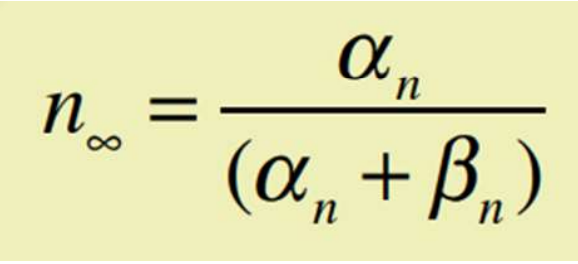
Donde el estado de alpha esta descrito por:
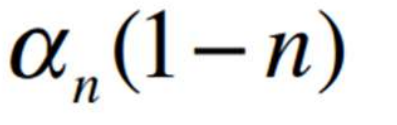
y el de beta por:
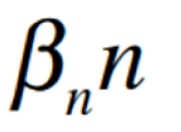

Nota: Solo en estas ecuaciones n significa la probabilida de abertura de las compuertas del canal ionico.

In [ ]:
class Gate:
    """The Gate object manages a channel's kinetics and open state"""
    alpha, beta, state = 0, 0, 0

    def update(self, deltaTms):
        alphaState = self.alpha*(1-self.state)
        betaState = self.beta*self.state
        self.state += deltaTms * (alphaState - betaState)

    def setInfiniteState(self):
        self.state = self.alpha/(self.beta+self.alpha)

**Definir funciones de activacion n, m & h**

Implemente las siguientes ecuaciones de activacion en la definicion de clases de las compuertas n, m & h.

![image.png](attachment:image.png)

Nota: Utilice numpy.exp para las exponenciales.

In [ ]:

class n_gate(Gate):
    def update_constants(self, Vm):
        self.alpha = 0.1 * ((10 - Vm) / (math.exp((10 - Vm) / 10) - 1))
        self.beta = 0.125 * math.exp(-Vm / 8)

class m_gate(Gate):
    def update_constants(self, Vm):
        self.alpha = 0.1 * ((25 - Vm) / (math.exp((25 - Vm) / 10) - 1))
        self.beta = 4 * math.exp(-Vm / 8)

class h_gate(Gate):
    def update_constants(self, Vm):
        self.alpha = 1 / (math.exp((30 - Vm) / 10) + 1)
        self.beta = 0.07 * math.exp(-Vm / 20)


**Definir modelo de H-H**

El siguiente objeto es la implementacion del modelo de H-H. En su mayoria, todo lo necesario para ejecutar la secuencia de pasos en el orden correcto esta dado. Su reto es integrar correctamente las variables faltantes del modelo en los espacios en donde el valor es `None`. Todas las variables requeridas ya existen dentro del objeto. No hay necesidad de crear nuevas variables.

In [ ]:
class HHModel:
    """The HHModel tracks conductances of 3 channels to calculate Vm"""

    ENa, EK, EKleak = 115, -12, 10.6
    gNa, gK, gKleak = 120, 36, 0.3
    Na_resp, K_resp = 0, 0
    INa, IK = 0, 0
    m, n, h = m_gate(), n_gate(), h_gate()
    Cm = 1

    def __init__(self, startingVoltage=0):
        self.Vm = startingVoltage
        self.UpdateGateTimeConstants(startingVoltage)
        self.UpdateInfiniteStates()

    def UpdateGateTimeConstants(self, Vm):
        """Update time constants of all gates based on the given Vm"""
        self.n.update_constants(Vm)
        self.m.update_constants(Vm)
        self.h.update_constants(Vm)

    def UpdateInfiniteStates(self):
        """Update infinite states of all gates based on the given Vm"""
        self.n.setInfiniteState()
        self.m.setInfiniteState()
        self.h.setInfiniteState()

    def UpdateCellVoltage(self, stimulusCurrent, deltaTms):
        """calculate channel currents using the latest gate time constants"""
        self.INa = np.power(self.Na_resp, 3) * self.gNa * self.h.state*(self.Vm-self.ENa)
        self.IK = np.power(self.K_resp, 4) * self.gK * (self.Vm-self.EK)
        IKleak = self.gKleak * (self.Vm-self.EKleak)
        Isum = stimulusCurrent - self.INa - self.IK - IKleak
        self.Vm += deltaTms * Isum / self.Cm

    def UpdateGateStates(self, deltaTms):
        """calculate new channel open states using latest Vm"""
        self.n.update(deltaTms)
        self.m.update(deltaTms)
        self.h.update(deltaTms)

    def Iterate(self, stimulusCurrent=0, deltaTms=0.05):
        self.UpdateGateTimeConstants(self.Vm)
        self.UpdateCellVoltage(stimulusCurrent, deltaTms)
        self.UpdateGateStates(deltaTms)


**Revisar respuesta del modelo de H-H**

Para evaluar la respuesta del modelo, simulara la inyeccion de diferentes niveles de corriente a la membrana de la neurona. Las amplitudes dadas son: 1, 2 y 10 uA/cm2.

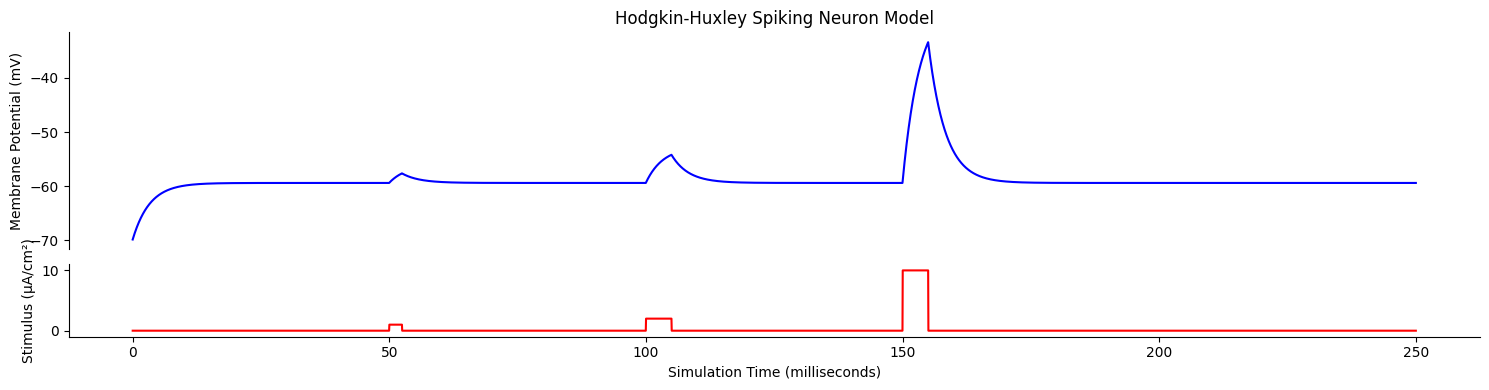

In [ ]:
hh = HHModel()
pointCount = 5000
voltages = np.empty(pointCount)
times = np.arange(pointCount) * 0.05
stim = np.zeros(pointCount)
stim[1000:1050] = 1
stim[2000:2100] = 2
stim[3000:3100] = 10

for i in range(len(times)):
    hh.Iterate(stimulusCurrent=stim[i], deltaTms=0.05)
    voltages[i] = hh.Vm

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 4),
                                gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(times, voltages - 70, 'b')
ax1.set_ylabel("Membrane Potential (mV)")
ax1.set_title("Hodgkin-Huxley Spiking Neuron Model")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(bottom=False)

ax2.plot(times, stim, 'r')
ax2.set_ylabel("Stimulus (µA/cm²)")
ax2.set_xlabel("Simulation Time (milliseconds)")
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.margins(0, 0.1)
plt.tight_layout()
plt.show()

**Revisar la respuesta de las funciones probabilisticas n, m & h**

La grafica a obtener sera comparable a la de respuesta de PA de la grafica anterior. La nueva grafica debera mostrar la evolucion de las funciones n, m & h en el tiempo conforme se va desarrollando un PA a travez de la membrana.

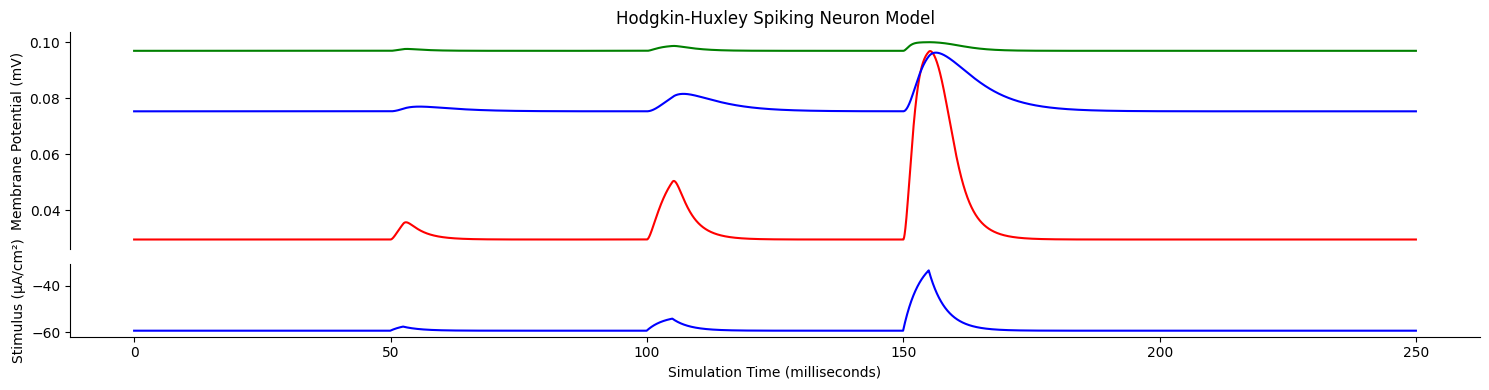

In [ ]:
voltages = np.empty(pointCount)
n_resp = np.empty(pointCount)
m_resp = np.empty(pointCount)
h_resp = np.empty(pointCount)

for i in range(len(times)):
    hh.Iterate(stimulusCurrent=stim[i], deltaTms=0.05)
    voltages[i] = hh.Vm
    n_resp[i] = hh.n.state
    m_resp[i]  = hh.m.state
    h_resp[i]  = hh.h.state

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 4),
                                gridspec_kw={'height_ratios': [3, 1]})


ax1.set_ylabel("Membrane Potential (mV)")
ax1.set_title("Hodgkin-Huxley Spiking Neuron Model") # , fontSize=16)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(bottom=False)
ax1.plot(times, n_resp/10, 'g')
ax1.plot(times, m_resp/10, 'r')
ax1.plot(times, h_resp/10, 'b')

ax2.plot(times, voltages - 70, 'b')
ax2.set_ylabel("Stimulus (µA/cm²)")
ax2.set_xlabel("Simulation Time (milliseconds)")
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.margins(0, 0.1)
plt.tight_layout()
plt.show()